<a href="https://colab.research.google.com/github/CiroGomess/speedrun/blob/master/projeto_cdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import missingno as msno
import time

### Documentação: https://github.com/speedruncomorg/api/tree/master/version1

## Consulta da API

Primeiramente, fazemos um request para a API, de forma que consigamos receber 200 jogos da base de dados do Speedrun.com

In [3]:
req = 'https://www.speedrun.com/api/v1/games?max=200'
games_data = requests.get(req)

In [4]:
df = pd.json_normalize(json.loads(games_data.text), record_path = ['data'])

Após isto, vamos obter alguns dados de plataformas e especificidades que estão codificadas no JSON que foi retornado dos jogos

In [5]:
req = 'https://www.speedrun.com/api/v1/platforms?max=200'
platforms_response = requests.get(req)

Fazendo alguma normalização para facilitar o momento em que os IDs de plataforma serão mapeados para os nomes da plataforma.

In [6]:
platforms = {}
for platform in json.loads(platforms_response.text)['data']:
  platforms[platform['id']] = platform['name']

In [7]:
df.head()

,id,boostReceived,boostDistinctDonors,abbreviation,weblink,discord,released,release-date,romhack,gametypes,...,moderators.8wky5m48,moderators.8e6lnk6j,moderators.x7wky5q8,moderators.y8dw2llj,moderators.0jm6kn81,moderators.qjo2mn38,moderators.18q64ddj,moderators.48g9gnrx,moderators.18q2o0q8,moderators.98rnvp3x
0,k6qqkx6g,0,0,fishy,https://www.speedrun.com/fishy,,2003,2003-02-02,False,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,268w4876,0,0,wild_russia,https://www.speedrun.com/wild_russia,,2020,2020-04-28,False,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3dx2pk41,0,0,findseed,https://www.speedrun.com/findseed,https://discord.gg/NXZyr48,2020,2020-02-22,True,[4xm721op],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,j1n83r91,0,0,happy_platformer,https://www.speedrun.com/happy_platformer,,2022,2022-05-22,False,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,y655yj46,0,0,_the_world,https://www.speedrun.com/_the_world,,2018,2018-02-02,False,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.columns 

Index(['id', 'boostReceived', 'boostDistinctDonors', 'abbreviation', 'weblink',
       'discord', 'released', 'release-date', 'romhack', 'gametypes',
       ...
       'moderators.8wky5m48', 'moderators.8e6lnk6j', 'moderators.x7wky5q8',
       'moderators.y8dw2llj', 'moderators.0jm6kn81', 'moderators.qjo2mn38',
       'moderators.18q64ddj', 'moderators.48g9gnrx', 'moderators.18q2o0q8',
       'moderators.98rnvp3x'],
      dtype='object', length=281)

In [9]:
df.isnull().sum()

id                       0
boostReceived            0
boostDistinctDonors      0
abbreviation             0
weblink                  0
                      ... 
moderators.qjo2mn38    199
moderators.18q64ddj    199
moderators.48g9gnrx    199
moderators.18q2o0q8    199
moderators.98rnvp3x    199
Length: 281, dtype: int64

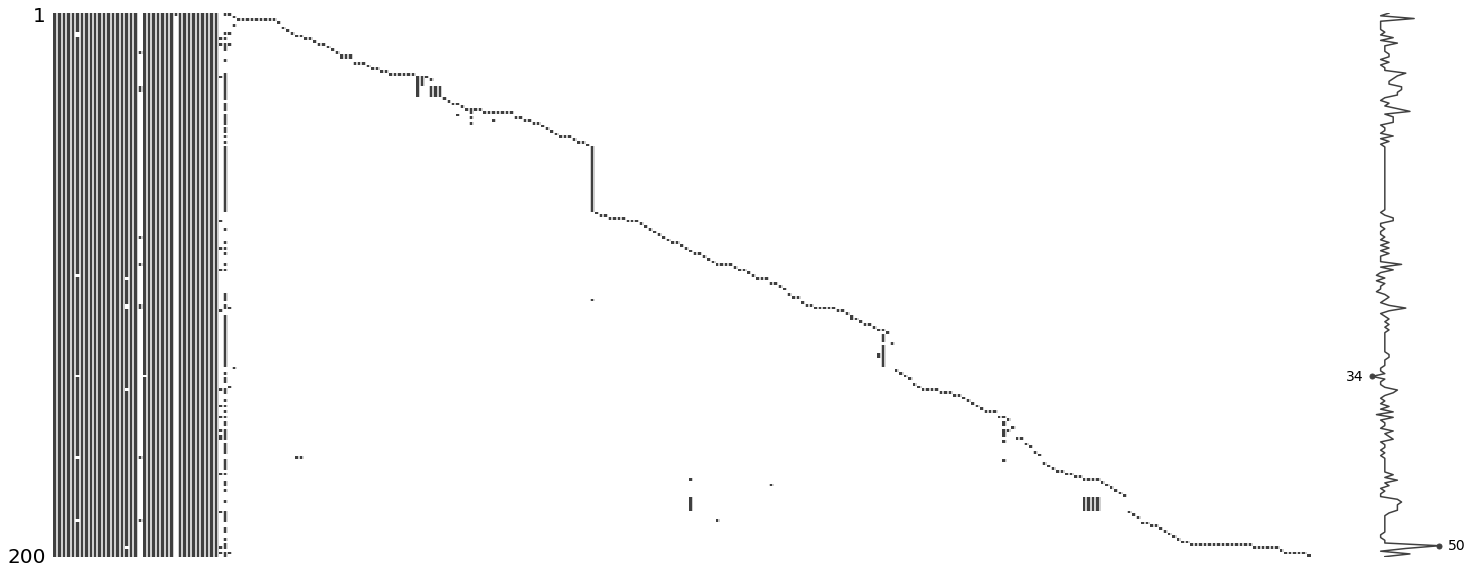

In [10]:
msno.matrix(df)

Como podemos ver, temos muitas colunas que não possuem utilidade ou não possuem tratamento de dados claro, portanto, vamos remover a maioria das colunas que se caracterizam como "sem tratamento de dados claro", usando um threshold de 10 valores nulos

In [11]:
df.dropna(1, any, 10, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """Entry point for launching an IPython kernel.


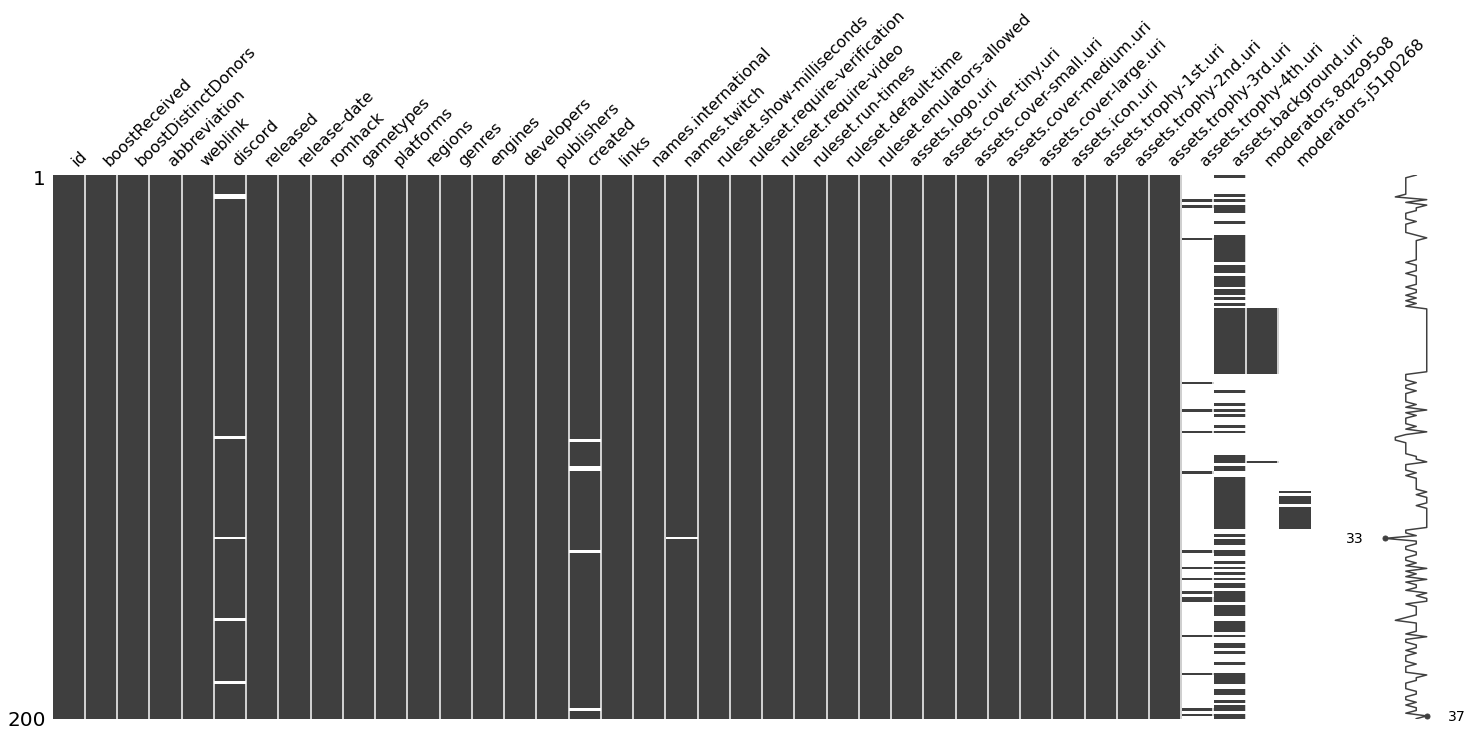

In [12]:
msno.matrix(df)

A partir daqui, retiraremos as colunas que estavam com o NaN disfarçado, bem como as colunas que não representam valor na análise de dados

In [13]:
cols = ['id', 'ruleset.show-milliseconds', 'ruleset.require-verification',
       'ruleset.require-video', 'ruleset.run-times', 'ruleset.default-time',
       'ruleset.emulators-allowed', 'assets.logo.uri', 'assets.cover-tiny.uri',
       'assets.cover-small.uri', 'assets.cover-medium.uri',
       'assets.cover-large.uri', 'assets.icon.uri', 'assets.trophy-1st.uri',
       'assets.trophy-2nd.uri', 'assets.trophy-3rd.uri',
       'assets.trophy-4th.uri', 'assets.background.uri', 'moderators.8qzo95o8',
       'moderators.j51p0268','boostReceived', 'boostDistinctDonors', 'abbreviation', 
        'weblink', 'names.twitch']

df.drop(columns=cols, inplace=True)

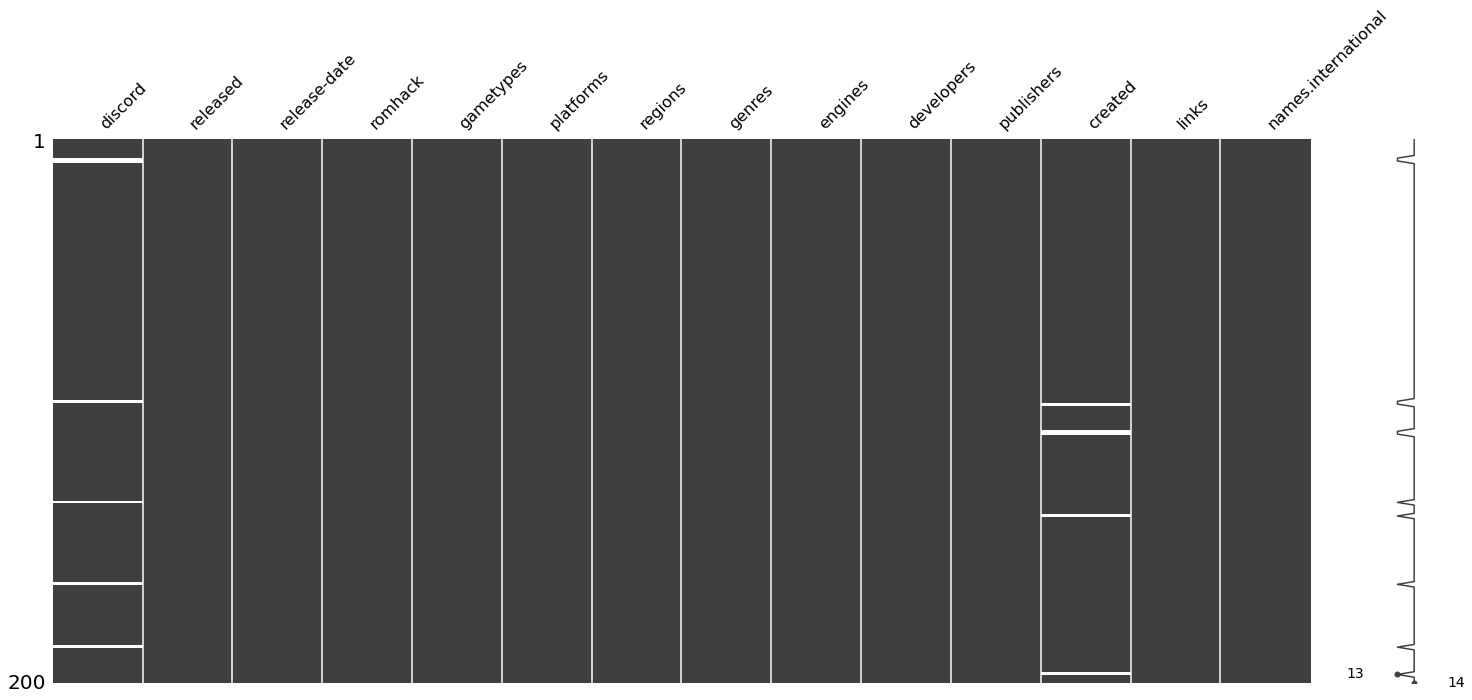

In [14]:
msno.matrix(df)

Aplicando a normalização de nomes dos jogos ao invés de IDs.

In [15]:
names = df.pop('names.international')
df.insert(0, 'name', names)

Trocando os ids discretos por nomes das plataformas

In [16]:
platforms_series = []
for platforms_encoded in df['platforms']:
  platforms_decoded = []
  for platform in platforms_encoded:
    platforms_decoded.append(platforms[platform])
  platforms_series.append(platforms_decoded)

df['platforms'] = pd.Series(platforms_series)

In [17]:
df

,name,discord,released,release-date,romhack,gametypes,platforms,regions,genres,engines,developers,publishers,created,links
0,! Fishy !,,2003,2003-02-02,False,[],[Web],[],[],[mg1j4w1r],[veg7rpe0],[],2016-05-28T23:21:12Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
1,! Wild Russia !,,2020,2020-04-28,False,[],[PC],[],[],[],[],[],2022-11-04T15:52:18Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
2,!findseed the map,https://discord.gg/NXZyr48,2020,2020-02-22,True,[4xm721op],"[PC, Macintosh, Linux]",[],[],[],[],[],2020-02-26T01:39:35Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
3,"""Happy"" Platformer",,2022,2022-05-22,False,[],[PC],[],[],[],[],[],2022-05-25T16:32:57Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
4,#21: The World,,2018,2018-02-02,False,[],[PC],[],[],[],[],[],2022-04-29T13:02:57Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020 Spring Collab,,2020,2020-09-09,True,[4xm721op],"[PC, Macintosh, Linux]",[],[qdnqkn8k],[],[],[],2021-05-12T20:21:18Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
196,2048,https://discordapp.com/invite/TYr6cxF,2014,2014-03-09,False,[],"[PC, Android, iOS, Windows Phone, Web]",[],[y45xyv2d],[],[rzj9pn6l],[9ne4lk65],None,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
197,2064: Read Only Memories,,2017,2017-01-17,False,[],"[PlayStation 4, PC]",[pr184lqn],[],[],[],[],2017-01-22T19:29:25Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."
198,20XX,https://discord.gg/DxbGJMs,2014,2014-11-24,False,[],[PC],[],"[qdnqkn8k, oq277z2l]",[],[],[],2016-09-18T23:38:01Z,"[{'rel': 'self', 'uri': 'https://www.speedrun...."


## Extração das Runs

A partir de aqui, dentro da coluna 'links', estão armazenados as requests que correspodem às runs, de cada jogo. Portanto, vamos extrair esses links e armazená-los em uma lista

In [18]:
runs = []

for j in range(len(df['links'])):
  runs.append(df['links'][j][1]['uri'])

Dentro da documentação da API, temos a seguinte situação:


1.   O limite de requests da API são de 100
2.   Após extrair as 100 requests, é preciso de 1 minuto para as próximas requests

Outra coisa que é interessante dizer é sobre o offset que, basicamente, desloca onde iremos iniciar a request, portanto, a lista 'offsets' foi feita de forma com que possamos passar por todas as requests presentes na lista 'runs'.

Colocamos estas requests em uma lista, assim como fizemos para os jogos e, para as requests não falharem, pela regra da API, colocamos um delay de 65s (esses 5s de segurança para garantir sucesso nas requests, encontrado após os testes).



In [19]:
jsons = []
offsets = ['&max=100', '&offset=100&max=100', '&offset=200&max=100', '&offset=300&max=100',
           '&offset=400&max=100', '&offset=500&max=100', '&offset=600&max=100']

for i in range(len(offsets)):
  for j, run in enumerate(runs):
    req = run + offsets[i]
    jsons.append(requests.get(req))
  if i == len(offsets):
    break
  else:
    time.sleep(65)

In [20]:
jsons[0].text # Retiramos o .json das runs de um jogo específico dessa forma, enquanto não resolvemos para todos os .json da lista

'{"data":[{"id":"7z0nvdem","weblink":"https://www.speedrun.com/fishy/run/7z0nvdem","game":"k6qqkx6g","level":null,"category":"rklgq3rd","videos":{"links":[{"uri":"https://youtu.be/-Vesbd8uJzE"}]},"comment":null,"status":{"status":"verified","examiner":"mkj9nw84","verify-date":"2016-05-29T00:31:08Z"},"players":[{"rel":"user","id":"mkj9nw84","uri":"https://www.speedrun.com/api/v1/users/mkj9nw84"}],"date":"2016-05-24","submitted":"2016-05-29T00:31:08Z","times":{"primary":"PT7M15S","primary_t":435,"realtime":"PT7M15S","realtime_t":435,"realtime_noloads":null,"realtime_noloads_t":0,"ingame":null,"ingame_t":0},"system":{"platform":"o7e25xew","emulated":false,"region":null},"splits":null,"values":{},"links":[{"rel":"self","uri":"https://www.speedrun.com/api/v1/runs/7z0nvdem"},{"rel":"game","uri":"https://www.speedrun.com/api/v1/games/k6qqkx6g"},{"rel":"category","uri":"https://www.speedrun.com/api/v1/categories/rklgq3rd"},{"rel":"platform","uri":"https://www.speedrun.com/api/v1/platforms/o7e2

In [21]:
df_runs = pd.json_normalize(json.loads(jsons[0].text), record_path = ['data'])

In [22]:
df_runs.head()

,id,weblink,game,level,category,comment,players,date,submitted,splits,...,times.realtime_noloads_t,times.ingame,times.ingame_t,system.platform,system.emulated,system.region,status.reason,splits.rel,splits.uri,videos.text
0,7z0nvdem,https://www.speedrun.com/fishy/run/7z0nvdem,k6qqkx6g,None,rklgq3rd,None,"[{'rel': 'user', 'id': 'mkj9nw84', 'uri': 'htt...",2016-05-24,2016-05-29T00:31:08Z,NaN,...,0,None,0,o7e25xew,False,None,NaN,NaN,NaN,NaN
1,oy2jl25z,https://www.speedrun.com/fishy/run/oy2jl25z,k6qqkx6g,None,rklgq3rd,Game can be found here: http://www.fishygame.org,"[{'rel': 'guest', 'name': 'MrBlie', 'uri': 'ht...",2014-01-05,2016-05-29T00:35:39Z,NaN,...,0,None,0,o7e25xew,False,None,NaN,NaN,NaN,NaN
2,7ylngdnz,https://www.speedrun.com/fishy/run/7ylngdnz,k6qqkx6g,None,rklgq3rd,Hier geht´s zum Spiel » http://www.maniacworl...,"[{'rel': 'guest', 'name': 'TheFabo', 'uri': 'h...",2015-05-22,2016-05-29T00:42:18Z,NaN,...,0,None,0,o7e25xew,False,None,NaN,NaN,NaN,NaN
3,nz1qw97y,https://www.speedrun.com/fishy/run/nz1qw97y,k6qqkx6g,None,rklgq3rd,I've managed to beat this game after quite som...,"[{'rel': 'guest', 'name': 'YOSUP72845', 'uri':...",2009-08-05,2016-05-29T00:46:07Z,NaN,...,0,None,0,o7e25xew,False,None,NaN,NaN,NaN,NaN
4,oy2jlr7z,https://www.speedrun.com/fishy/run/oy2jlr7z,k6qqkx6g,None,rklgq3rd,None,"[{'rel': 'user', 'id': 'mkj9nw84', 'uri': 'htt...",2016-05-29,2016-05-29T07:26:50Z,NaN,...,0,None,0,o7e25xew,False,None,NaN,NaN,NaN,NaN


In [23]:
df_runs.columns

Index(['id', 'weblink', 'game', 'level', 'category', 'comment', 'players',
       'date', 'submitted', 'splits', 'links', 'videos.links', 'status.status',
       'status.examiner', 'status.verify-date', 'times.primary',
       'times.primary_t', 'times.realtime', 'times.realtime_t',
       'times.realtime_noloads', 'times.realtime_noloads_t', 'times.ingame',
       'times.ingame_t', 'system.platform', 'system.emulated', 'system.region',
       'status.reason', 'splits.rel', 'splits.uri', 'videos.text'],
      dtype='object')

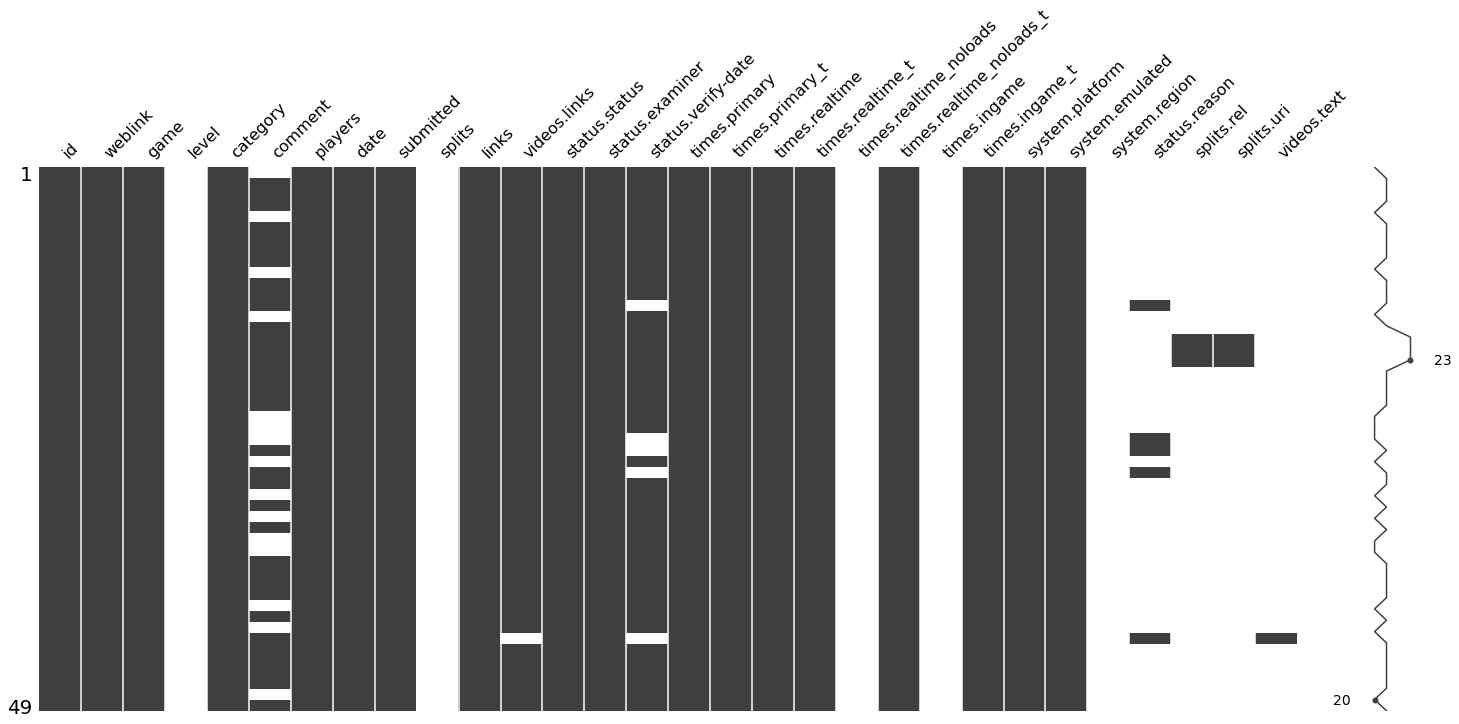

In [24]:
msno.matrix(df_runs)

Vemos, pelo gráfico, que este dataframe também possui vários valores NaN, alguns deles que não conseguimos tratar, portanto, iremos retirá-los

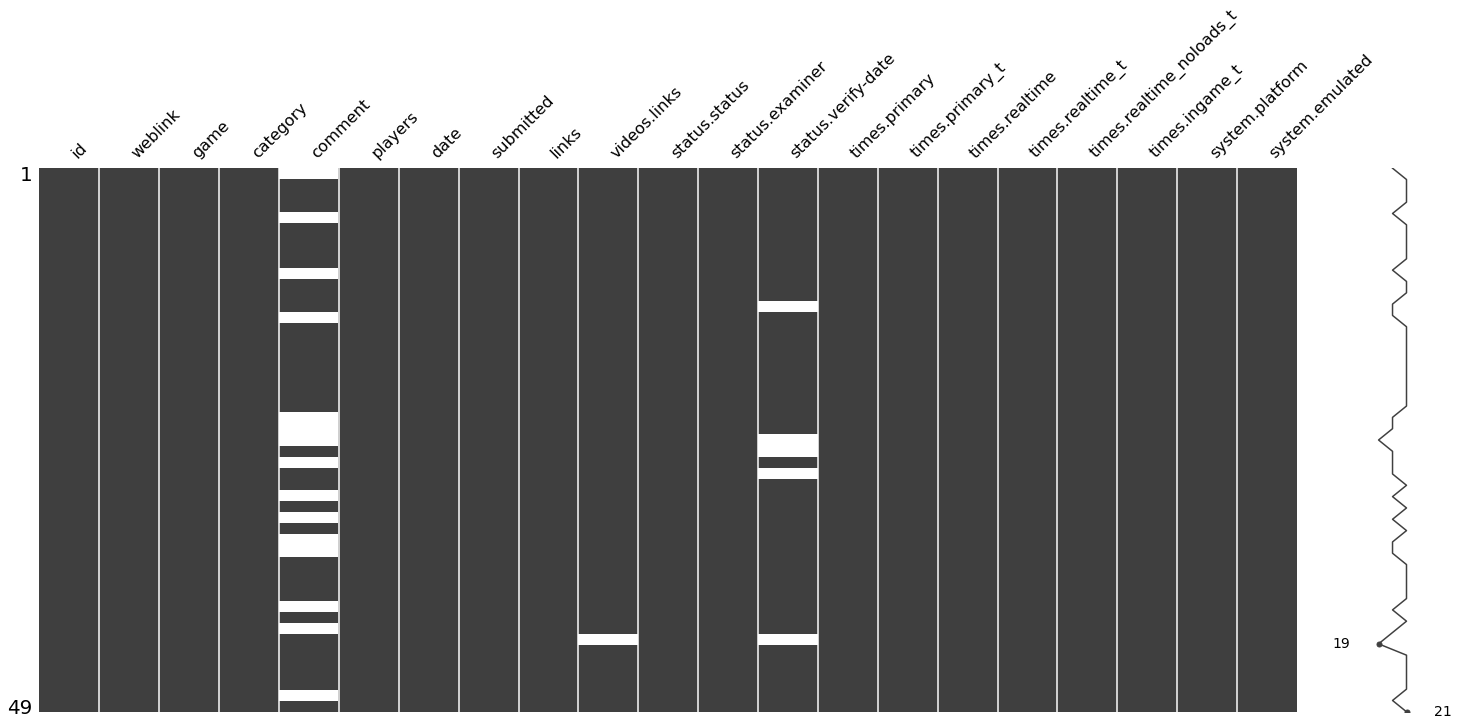

In [25]:
cols_to_remove = ['system.region', 'level', 'splits', 'times.realtime_noloads',
                  'status.reason', 'splits.rel', 'splits.uri', 'videos.text',
                  'times.ingame']

df_runs.drop(columns=cols_to_remove, inplace=True)
msno.matrix(df_runs)

## Análise de Centralidade

In [26]:
df_runs.describe()

,times.primary_t,times.realtime_t,times.realtime_noloads_t,times.ingame_t
count,49.000000,49.000000,49.0,49.0
mean,456.224490,456.224490,0.0,0.0
std,121.084555,121.084555,0.0,0.0
min,300.000000,300.000000,0.0,0.0
25%,388.000000,388.000000,0.0,0.0
50%,435.000000,435.000000,0.0,0.0
75%,489.000000,489.000000,0.0,0.0
max,1010.000000,1010.000000,0.0,0.0


Como podemos ver, os dados numéricos, por enquanto, estão nos mostrando a mesma informação, pelo que o describe está nos mostrando. Infelizmente, não estão armazenadas, para esse conjunto de dados, o tempo com as telas de loading removidas, que podiam servir para uma análise mais profunda desses dados. A mediana e a média estão com valores bem próximos, que é um sinal da base estar bem balanceada, nesse quesito, implicando que os tempos das runs feitas pelos jogadores são bastantes próximos, indicando que o cenário, para este jogo, é relativamente competitivo. 

## Análise por Gráficos de Dispersão

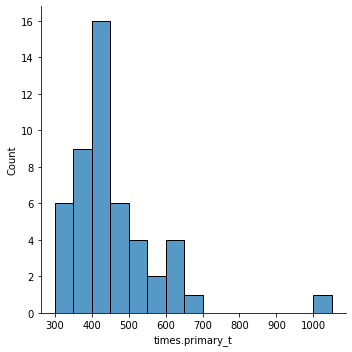

In [27]:
sns.displot(df_runs, x="times.primary_t", binwidth=50)

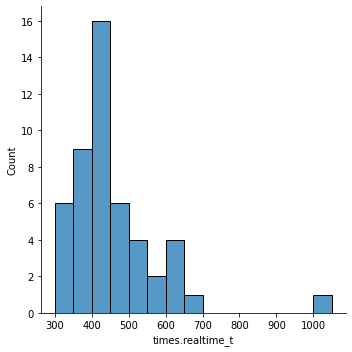

In [28]:
sns.displot(df_runs, x="times.realtime_t", binwidth=50)

Visualmente falando, conseguimos observar que os tempos primary e realtime são praticamente iguais. Como foi confirmado na análise da centralidade, conseguimos atestar, novamente, que os dados estão bem distribuídos, com excessão de uma ocorrência acima da média, de valor maior que 1000 segundos.

## Análise do Boxplot

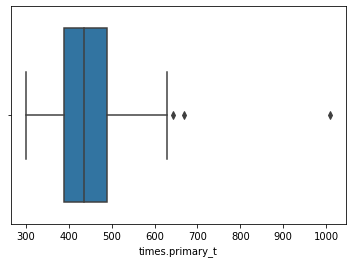

In [29]:
sns.boxplot(x=df_runs["times.primary_t"])

Mais uma vez, o boxplot condiz com as análises anteriores, no entanto, vemos alguns outliers menos "gritantes" que os presentes em 1000 segundos para frente, que não conseguimos enxergar, anteriormente, devido à quantidade de bins escolhidas para os gráficos de dispersão.

Análise de gráficos de linha